## Imports

In [1]:
import numpy as np
import pandas as pd
import gc
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product


from scipy import spatial, cluster
import pymn

from scipy import stats
import joypy

In [2]:
from rank import rank
from egad import run_egad

In [3]:
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from move_seaborn_legend import move_legend

## Functions

## Load Reference Data

In [6]:
import h5py

In [7]:
f = h5py.File('/home/bharris/GO_data/GO_human_no_repl_fast.h5', 'r')
go_human = f['nw'][:]
go_terms = f['goterms'][:]
go_genes = f['hgnc'][:]
go_human_all = pd.DataFrame(go_human, index=go_genes, columns=go_terms)
f.close()
go_slim = np.genfromtxt('/home/bharris/GO_data/aug4.GOslim', dtype=str)

go_human_slim = go_human_all[np.intersect1d(go_slim, go_terms)]


## Build AnData

In [8]:
hemberg_metadata = pd.read_csv(
    '/data/bharris/single_cell_data/hemberg_pancreas/hemberg_metadata.csv',
    index_col=0)
hemberg_genes = np.genfromtxt(
    '/data/bharris/single_cell_data/hemberg_pancreas/hemberg_genes.csv',
    dtype=str)

In [9]:
hemberg = sc.read_mtx(
    '/data/bharris/single_cell_data/hemberg_pancreas/hemberg_counts.mtx').T
hemberg.obs = hemberg_metadata
hemberg.var_names = hemberg_genes

hemberg = hemberg[~hemberg.obs['cell.type'].isnull()]

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [10]:
for study in hemberg.obs.study_id.unique():
    andata = hemberg[hemberg.obs.study_id == study]
    andata.write_loom(
        f'/data/bharris/single_cell_data/hemberg_pancreas/{study}_raw.loom')
    del andata
    gc.collect()

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Compute Genes for networks

In [11]:
highly_expressed = pd.DataFrame(index=hemberg.var_names)
for study in hemberg.obs.study_id.unique():
    andata = hemberg[hemberg.obs.study_id == study]
    highly_expressed[study] = np.ravel(andata.X.sum(axis=0))

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


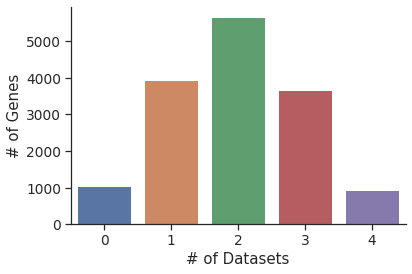

In [12]:
gene_recurrence = (highly_expressed.apply(np.argsort) >
                   highly_expressed.shape[0] - 7500).sum(axis=1)
ax = sns.countplot(gene_recurrence)
ax.set(xlabel='# of Datasets', ylabel='# of Genes')

plt.show()

In [13]:
hemberg_highly_expressed = gene_recurrence.index.values
np.savetxt(
    '/home/bharris/biccn_paper/data/pancreas/hemberg_highly_expressed_genes.csv',
    hemberg_highly_expressed,
    fmt='%s')

## Prepare Markers

In [14]:
markers_data = pd.read_csv(
    '/home/bharris/biccn_paper/data/pancreas/markers/meta_markers.csv.gz',
    skiprows=1)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


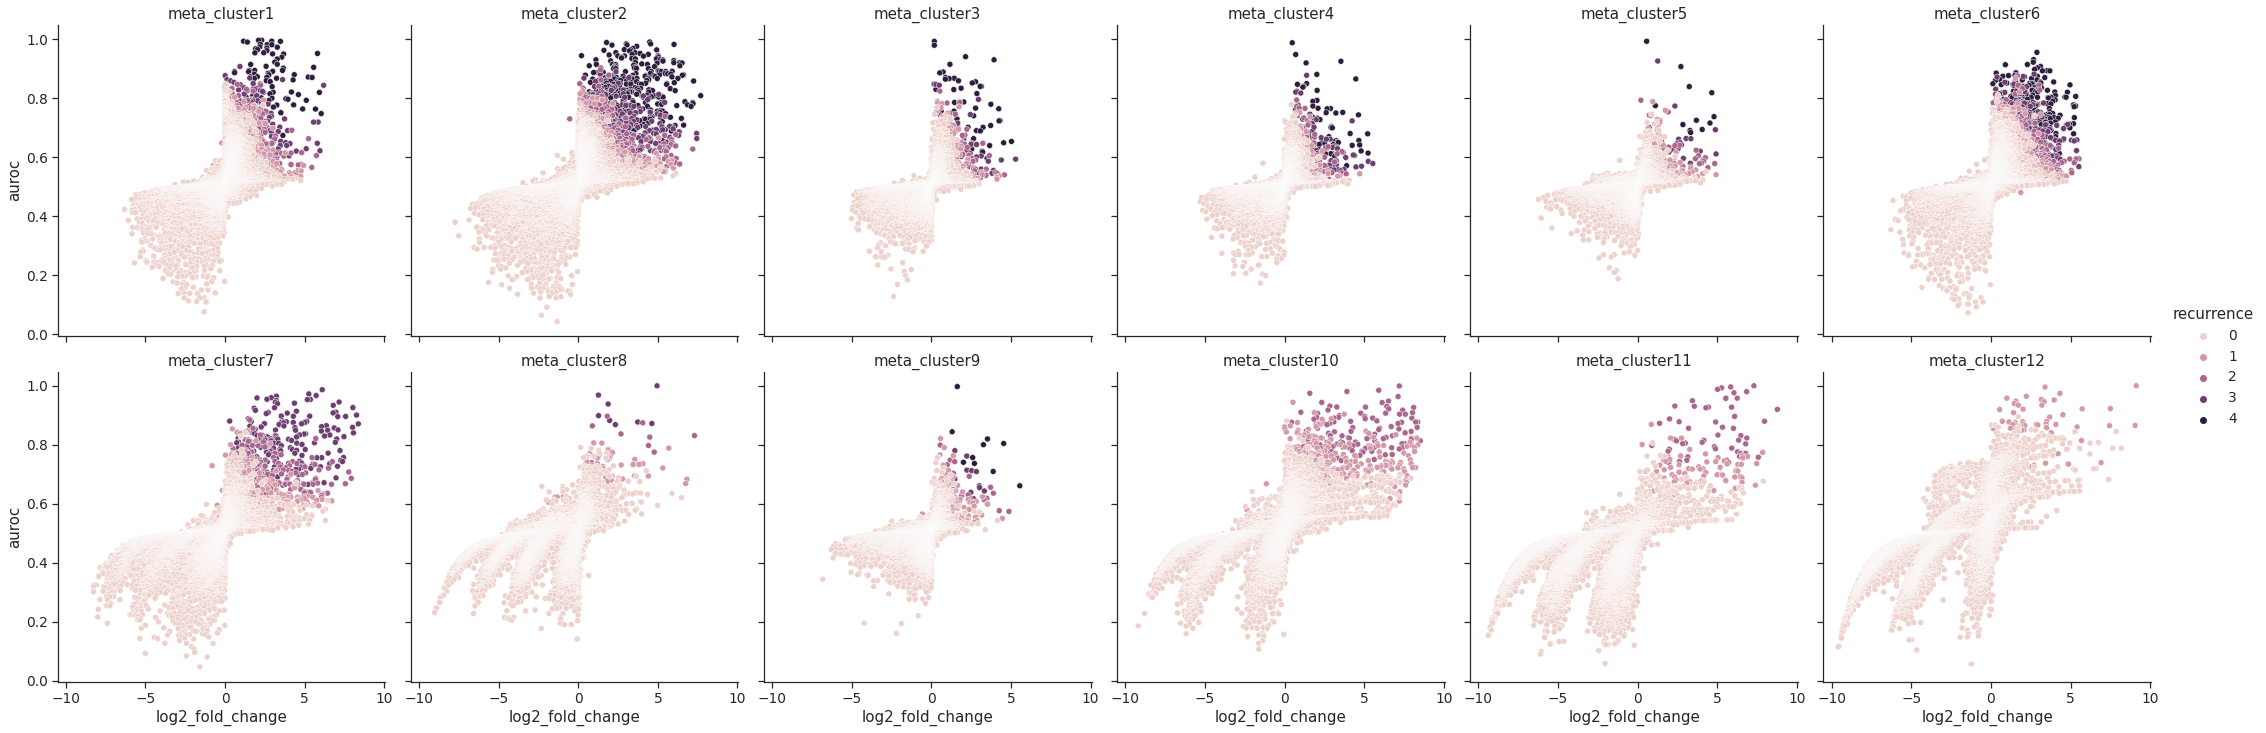

In [15]:
markers_data['log2_fold_change'] = np.log2(markers_data.fold_change_detection)
g = sns.relplot(data=markers_data,
                col='cell_type',
                x='log2_fold_change',
                y='auroc',
                hue='recurrence',
                col_wrap=6,
                col_order=[f'meta_cluster{i}' for i in range(1, 13)],
                kind='scatter')
g.set_titles("{col_name}")
plt.show()

In [15]:
markers_df = pd.get_dummies(
    markers_data.query('rank<=100 & auroc > .6')[[
        'cell_type', 'gene'
    ]].set_index('gene')['cell_type']).reset_index().groupby('gene').sum()
markers_df = markers_df.reindex(hemberg_highly_expressed).fillna(0)

## Compute full Dataset networks

In [16]:
for study in hemberg.obs.study_id.unique():
    andata = hemberg[hemberg.obs.study_id == study]
    sc.pp.normalize_total(andata, target_sum=1e6)
    andata = andata[:, hemberg_highly_expressed]
    nw = np.corrcoef(andata.X.todense().T)
    rank(nw)
    nw = pd.DataFrame(nw,
                      index=hemberg_highly_expressed,
                      columns=hemberg_highly_expressed)
    nw.to_hdf(
        f'~/biccn_paper/data/pancreas/networks/full_dataset_nw_{study}.hdf5',
        'nw')
    print(study,
          run_egad(go_human_slim, nw).AUC.mean(),
          run_egad(markers_df, nw).AUC.mean())
    del andata, nw
    gc.collect()

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[

baron 0.6388207150157853 0.9678673053850838


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[

lawlor 0.6059106871378429 0.9460680679153072


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[

seger 0.6271245718043259 0.9693866491269439


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[

muraro 0.6294022223107872 0.9675630016951061


In [17]:
agg_full_nw = np.zeros(
    [hemberg_highly_expressed.shape[0], hemberg_highly_expressed.shape[0]])
for study in hemberg.obs.study_id.unique():
    nw = pd.read_hdf(
        f'~/biccn_paper/data/pancreas/networks/full_dataset_nw_{study}.hdf5',
        'nw')
    agg_full_nw += nw.values
    del nw
    gc.collect()
rank(agg_full_nw)
np.fill_diagonal(agg_full_nw, 1)
agg_full_nw = pd.DataFrame(agg_full_nw,
                           index=hemberg_highly_expressed,
                           columns=hemberg_highly_expressed)
agg_full_nw.to_hdf(
    '/home/bharris/biccn_paper/data/pancreas/networks/agg_full_dataset_nw.hdf5',
    'nw')

In [18]:
run_egad(go_human_slim, agg_full_nw).AUC.mean()

0.6561067269556148

In [19]:
run_egad(markers_df, agg_full_nw).AUC.mean()

0.9729140531448334

## Aggregate Metacluster Networks

In [20]:
agg_mc_nw = np.zeros(
    [hemberg_highly_expressed.shape[0], hemberg_highly_expressed.shape[0]])
for study in hemberg.obs.study_id.unique():
    nw = pd.read_hdf(
        f'/home/bharris/biccn_paper/data/pancreas/networks/{study}_metacluster_aggregated.hdf5',
        'nw')
    print(study,
          run_egad(go_human_slim, nw).AUC.mean(),
          run_egad(markers_df, nw).AUC.mean())
    agg_mc_nw += nw.values
    del nw
    gc.collect()
rank(agg_mc_nw)
agg_mc_nw = pd.DataFrame(agg_mc_nw,
                         index=hemberg_highly_expressed,
                         columns=hemberg_highly_expressed)
agg_mc_nw.to_hdf(
    '/home/bharris/biccn_paper/data/pancreas/networks/agg_metacluster_nw.hdf5',
    'nw')

baron 0.6496640501496526 0.9140442638163138
lawlor 0.5959444561828925 0.8494959821331762
seger 0.6493590243721965 0.8872337677258647
muraro 0.6476209210931537 0.9522240406090918


In [21]:
run_egad(go_human_slim, agg_mc_nw).AUC.mean()

0.6843676343260273

In [22]:
run_egad(markers_df, agg_mc_nw).AUC.mean()

0.9730974203128983

## Compare Performance

In [24]:
full_nw_go = run_egad(go_human_slim, agg_full_nw)
metacell_nw_go = run_egad(go_human_slim, agg_mc_nw)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


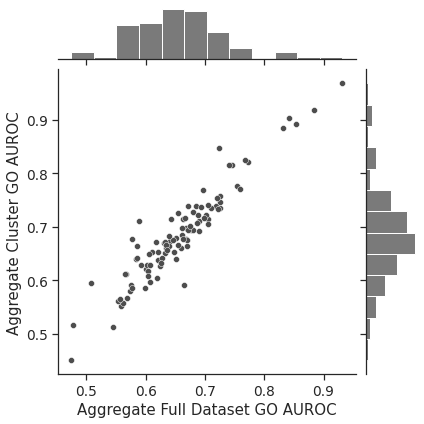

In [32]:
g = sns.jointplot(full_nw_go.AUC, metacell_nw_go.AUC, color='.3')
g.ax_joint.set(xlabel='Aggregate Full Dataset GO AUROC',
               ylabel='Aggregate Cluster GO AUROC')

plt.savefig('/home/bharris/biccn_paper/figures/resub/pancreas_GO.pdf',
            transparent=True)

In [26]:
stats.spearmanr(full_nw_go.AUC, metacell_nw_go.AUC)

SpearmanrResult(correlation=0.9183558355835583, pvalue=3.0850822898779763e-41)

In [23]:
full_nw_markers = run_egad(markers_df, agg_full_nw)
metacell_nw_markers = run_egad(markers_df, agg_mc_nw)

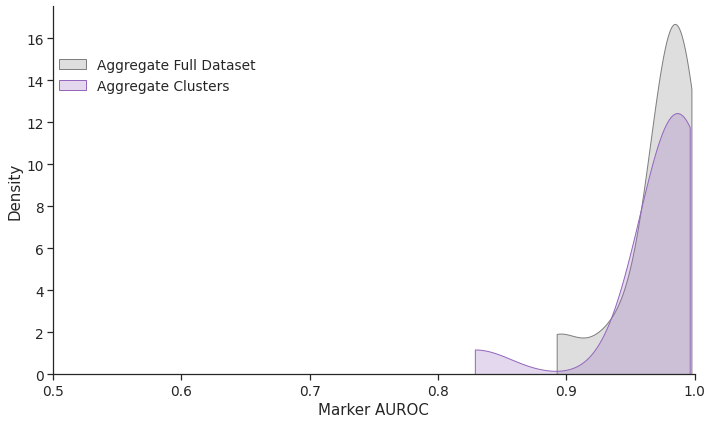

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(full_nw_markers.AUC,
            fill=True,
            label='Aggregate Full Dataset',
            color='tab:gray',
            cut=0,
            ax=ax)
sns.kdeplot(metacell_nw_markers.AUC,
            fill=True,
            label='Aggregate Clusters',
            color='tab:purple',
            cut=0,
            ax=ax)
ax.legend(loc=[0, .75], frameon=False)
ax.set(xlabel='Marker AUROC', xlim=[.5, 1])
ax.axvline(.5, ls='--', c='r')
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/resub/pancreas_marker.pdf',
            transparent=True)